In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get the current working directory + desired directory
parent_directory = os.getcwd()
main_directory = parent_directory + '/drive/MyDrive/2024 UW ENGINE Capstone'
curr_directory = main_directory + '/data/GMD and GIC'

In [3]:
## Event ID, Device_IDs, File path, time column name, and GIC column name
eventDate = 20131002 # YYYYMMDD

# Location Dataframe for Devices (e.g Latitude / Longitude )
loc_file = curr_directory + '/event_' + str(eventDate) + '/GIC/gic_monitors.csv'
loc_df = pd.read_csv(loc_file) # create df for locations based on device ID

# Make Longitude Negative (indicating West)
device_IDs = loc_df['Device ID'] # Series
loc_df.rename(columns={' Latitude': 'Latitude'}, inplace=True) # Change column title to remove extra space
loc_df.rename(columns={' Longitude': 'Longitude'}, inplace=True) # Change column title to remove extra space
loc_df['Longitude'] = loc_df['Longitude']*-1

# device_IDs = [10358, 10195, 10211, 10212, 10251, 10252] # from gic_monitors.csv
file_paths = ['/' + str(eventDate)[0:4] +'E02_' + str(id) + '.csv' for id in device_IDs]
time_column = 'SampleDateTime'
gic_column = 'GICMeasured'

# Make complete file_paths with current working directory
for i in range(len(file_paths)):
    file_paths[i] = curr_directory + '/event_' + str(eventDate) + '/GIC' + file_paths[i]

# View example of file path
file_paths[0]

'/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10056.csv'

In [4]:
# Filter location dataframe for desired Device IDs
filtered_loc_df = loc_df[loc_df['Device ID'].isin(device_IDs)]

# A dict for storing resampled data
resampled_data = {}

# Extract the time and determine the common time point for each GIC file
for file_path, latitude, id in zip(file_paths, filtered_loc_df['Latitude'], filtered_loc_df['Device ID']):
    df = pd.read_csv(file_path, usecols=[time_column, gic_column]) # read the data .csv file
    df[time_column] = pd.to_datetime(df[time_column]) # convert to pandas format
    # Set the datetime object as an index
    df.set_index(time_column, inplace=True)
    # Store resampling data for each file (key, value)
    resampled_data[id] = df.resample('T').mean().interpolate(method='spline', order=3)  # 'T' stands for every minute


<ipython-input-4-f0041a5c79ef>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column]) # convert to pandas format
<ipython-input-4-f0041a5c79ef>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column]) # convert to pandas format
<ipython-input-4-f0041a5c79ef>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column]) # convert to pandas format
<ipython-input-4-f0041a5c79ef>:10: UserWarning: Could not infer format, so each element will be parsed ind

In [13]:
# Create dict for detail coefficient
detail_coeffs_list = {}

# Conduct Haar wavedecomposition of GIC data
for i, id in zip(file_paths, filtered_loc_df['Device ID']):
    data = resampled_data[id]
    coeffs = pywt.wavedec(data[gic_column], 'haar', level=2)
    detail_coeffs_list[id] = np.abs(coeffs[0])

In [14]:
# Create new time index
original_index = resampled_data[device_IDs[0]].index
original_index.shape[0]/4

405.25

In [15]:
new_index = original_index[::4]
new_index.shape[0]

406

In [16]:
new_time_str = new_index.strftime('%Y-%m-%d %H:%M:%S').tolist()
len(new_time_str)

406

In [17]:
print(len(detail_coeffs_list))

87


In [18]:
# Create the time frame GIC coefficients
df_gic = pd.DataFrame()
omit = []

for i in detail_coeffs_list:
  if len(detail_coeffs_list[i]) != len(new_time_str):
    omit.append(i)
    print(f"Shape is not aligned: ID = {i}")

for i in detail_coeffs_list:
  if i not in omit:
    df_gic[i] = pd.DataFrame(detail_coeffs_list[i], index=new_time_str)


Shape is not aligned: ID = 10094
Shape is not aligned: ID = 10425


<Axes: xlabel='Time', ylabel='Device ID'>

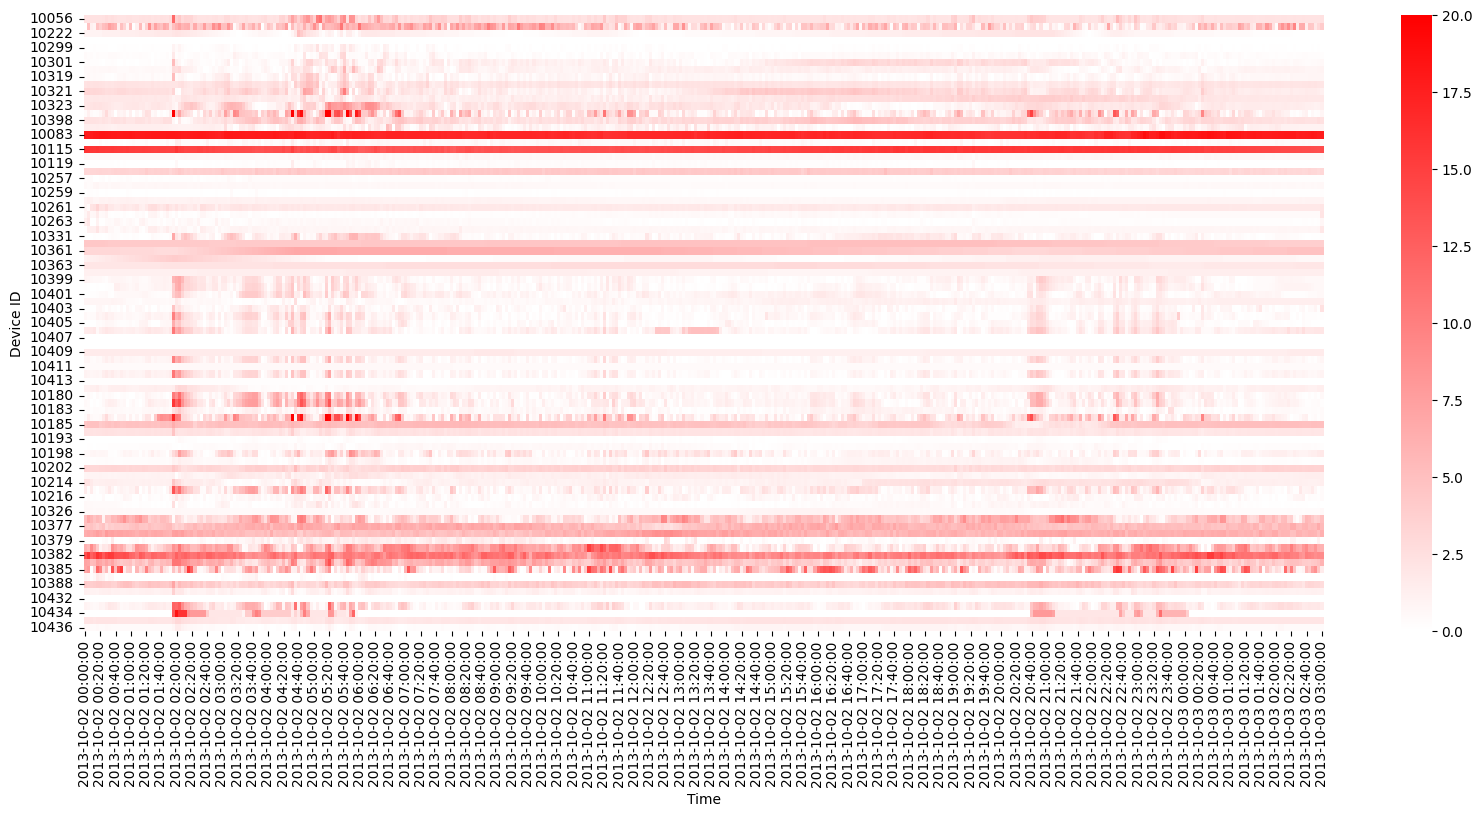

In [19]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

colors = ["white", 'red']
cmap = LinearSegmentedColormap.from_list("custom_cmap",colors)

# By Device ID
df_transposed = df_gic.transpose()
df_transposed.index.name = 'Device ID'
df_transposed.columns.name = 'Time'
# print(df_transposed.head())

sns.set_context({"figure.figsize":(20,8)})
sns.heatmap(data=df_transposed,vmin=0, vmax=20,cmap=cmap)

In [ ]:
# By Latitude
device_lat_dict = dict(zip(filtered_loc_df['Device ID'], filtered_loc_df['Latitude']))
df_gic_lat = df_gic.rename(columns=device_lat_dict)

df_transposed = df_gic_lat.transpose()
df_transposed_sorted = df_transposed.sort_index(axis=0,ascending=False)
df_transposed_sorted.index.name = 'Latitude'
df_transposed_sorted.columns.name = 'Time'

sns.set_context({"figure.figsize":(20,8)})
sns.heatmap(data=df_transposed_sorted,vmin=0, vmax=20,cmap=cmap)

In [ ]:
# Omit device not aligned
for i in omit:
    filtered_loc_df = filtered_loc_df[filtered_loc_df['Device ID'] != i]

if 10425 in filtered_loc_df['Device ID'].values:
  print("yes")
else:
  print('no')
device_id = 10425
if device_id in df_gic.keys():
  print("yes")
if str(device_id) in df_gic.columns:
    print("Yes, 'device_id' is a column in the DataFrame.")

print(df_gic[10056].min())

df_gic.keys()


In [ ]:
import plotly.graph_objects as go
import pandas as pd
# Define a color scale based on GIC
color_scale = [(0, 'blue'), (1, 'red')]

# Create scattermapbox traces for each device
traces = []
frames = []

# Loop through each device in filtered_loc_df
for i, row in filtered_loc_df.iterrows():
    device_id = row['Device ID']
    lat = row['Latitude']
    lon = row['Longitude']

    # Create scattermapbox trace for each device
    trace = go.Scattermapbox(
        lat=[lat],
        lon=[lon],
        mode='markers',
        marker=dict(
            size=10,
            color='blue',
            colorscale=color_scale,
            cmin=df_gic[device_id].min(),
            cmax=df_gic[device_id].max(),
        ),
        text=[f"Device ID: {device_id}<br>GIC: {temp}" for temp in df_gic[device_id]],
        hoverinfo='text',
        name=f'Device ID: {device_id}'
    )
    traces.append(trace)

# Create frames for each time point in df_gic
for time_point in df_gic.index:
    data = []
    for i, row in filtered_loc_df.iterrows():
        device_id = row['Device ID']
        lat = row['Latitude']
        lon = row['Longitude']
        val = df_gic.loc[time_point, device_id]
        marker_size = abs(val) * 2 + 5  # Adjust marker size based on value + min to see on chart
        trace = go.Scattermapbox(
            lat=[lat],
            lon=[lon],
            mode='markers',
            marker=dict(
                size=marker_size,
                color=val,
                colorscale=color_scale,
                cmin=df_gic.min().min(),
                cmax=df_gic.max().max(),
            ),
            text=f"Device ID: {device_id}<br> GIC: {val}",
            hoverinfo='text',
            name=f'Device ID: {device_id}'
        )
        data.append(trace)
    frame = go.Frame(data=data, name=str(time_point))
    frames.append(frame)

# Define the updatemenus with play and pause buttons
updatemenus = [
    dict(
        type="buttons",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 100}, "fromcurrent": True}]),
                 dict(label="Pause",
                      method="animate",
                      args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])],
        direction="left",
        pad={"r": 10, "t": 10},
        showactive=False,
        x=0,
        xanchor="left",
        y=0,
        yanchor="bottom"
    )
]

# Create sliders for each time point
sliders = [dict(
    steps=[dict(
        args=[
            [str(time_point)],
            {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}
        ],
        label=str(time_point),
        method="animate"
    ) for time_point in df_gic.index],
    active=0,
    pad={"t": 50},
)]

# Set up the layout of the map
layout = go.Layout(
    title='GIC Variation after Wavelet Decomposition',
    mapbox=dict(
        style="carto-positron",  # Choose a map style
        zoom=3,  # Set initial zoom level
        center=dict(lat=37.0902, lon=-95.7129),  # Center the map on the U.S.
    ),
    updatemenus=updatemenus,
    sliders=sliders,
    width=1920,  # Set the width of the canvas
    height=900,
    legend=dict(x=0, y=1)  # Adjust the legend position
)

# Create the figure with frames
fig = go.Figure(data=traces, layout=layout, frames=frames)

# Display the map
fig.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Example GeoDataFrame
# Replace this with your GeoDataFrame
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot GeoDataFrame using Geopandas (Matplotlib plot)
ax = gdf.plot(figsize=(10, 6), color='lightblue', edgecolor='black')

# Convert the Matplotlib plot to a Plotly figure
fig = go.Figure()

# Extract the Matplotlib plot as an image and add it to the Plotly figure
fig.add_layout_image(
    dict(
        source=plt.savefig("temp.png"),  # Save the Matplotlib plot as a temporary image
        x=0,
        sizex=1,
        y=0,
        sizey=1,
        xref="paper",
        yref="paper",
        opacity=1.0,
        layer="below"
    )
)

# Adjust layout if necessary
fig.update_layout(
    title="GeoDataFrame Plot converted to Plotly",
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
)

# Show the Plotly figure
fig.show()
